# Caderno 11 - Calcula métricas considerando os resultados de pesquisa em um BM25 com expansão de documentos com doc2query (considera 5 queries) e sinônimos gerados com Llama e GPT

In [1]:
# Se True, refaz a indexação. Se False, tenta recuperar o
# índice do arquivo indice_js_enunciado_e_excerto.pickle.
# É necessário que esse arquivo exista.
REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY_SINONIMOS_LLAMA = False
REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY_SINONIMOS_GPT = False

PASTA_DADOS = './dados/'
PASTA_RESULTADO_CADERNO = f'{PASTA_DADOS}outputs/11_metricas_bm25_com_doc2query_e_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_LLAMA = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_doc2query_5q_e_llama.pickle'
NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_GPT = f'{PASTA_RESULTADO_CADERNO}indice_js_enunciado_e_excerto_e_doc2query_5q_e_gpt.pickle'

## 1. Carrega base de dados
Carrega a lista de documentos para indexar, as queries para testar e o qrels.

In [2]:
import pandas as pd

# A pasta dos JURIS aqui não é a pasta original, e sim o resultado do caderno 1 (os documentos já estão filtrados)
PASTA_JURIS_TCU = f'{PASTA_DADOS}outputs/1_tratamento_juris_tcu/'

# Carrega os arquivos 
def carrega_juris_tcu():
    doc1 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_1.csv', sep='|')
    doc2 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_2.csv', sep='|')
    doc3 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_3.csv', sep='|')
    doc4 = pd.read_csv(f'{PASTA_JURIS_TCU}doc_tratado_parte_4.csv', sep='|')
    doc = pd.concat([doc1, doc2, doc3, doc4], ignore_index=True)
    query = pd.read_csv(f'{PASTA_JURIS_TCU}query_tratado.csv', sep='|')
    qrel = pd.read_csv(f'{PASTA_JURIS_TCU}qrel_tratado.csv', sep='|')

    return doc, query, qrel

docs, queries, qrels = carrega_juris_tcu()

Carrega a geração de queries por documento gerada no caderno 5 e a geração de sinônimos usando GPT e Llama geradas no caderno 9.

In [3]:
import pickle

PASTA_CADERNO_DOC2QUERY = f'{PASTA_DADOS}outputs/5_doc2query/'
NOME_ARQUIVO_DOC2QUERY = f'{PASTA_CADERNO_DOC2QUERY}doc2query.pickle'

with open(NOME_ARQUIVO_DOC2QUERY, 'rb') as f:
    queries_por_doc = pickle.load(f)

PASTA_CADERNO_REESCRITA_GPT_LLAMA = f'{PASTA_DADOS}outputs/9_sinonimos_enunciado_gpt_llama/'
NOME_ARQUIVO_RESULTADO_LLAMA = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}sinonimos_enunciados_llama.pickle'
NOME_ARQUIVO_RESULTADO_GPT = f'{PASTA_CADERNO_REESCRITA_GPT_LLAMA}sinonimos_enunciados_gpt.pickle'

with open(NOME_ARQUIVO_RESULTADO_LLAMA, 'rb') as f:
    enunciado_llama_por_doc = pickle.load(f)
with open(NOME_ARQUIVO_RESULTADO_GPT, 'rb') as f:
    enunciado_gpt_por_doc = pickle.load(f)

Insere essas reescritas no dataframe documentos.

In [4]:
# No caso do doc2query, é um vetor com as 5 queries
docs['DOC2QUERY'] = docs['KEY'].map(lambda key: " ".join(set(queries_por_doc[key])) )
# No caso dos sinônimos, é um campo string
docs['ENUNCIADO_LLAMA'] = docs['KEY'].map(lambda key: enunciado_llama_por_doc[key])
docs['ENUNCIADO_GPT'] = docs['KEY'].map(lambda key: enunciado_gpt_por_doc[key])

## 2. Instancia um BM25 e indexa os campos ENUNCIADO e EXCERTO e as queries expandidas

In [5]:
from bm25 import IndiceInvertido, BM25, tokenizador_pt_remove_html

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\caris\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [6]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e as queries geradas com o doc2query e os sinônimos usando Llama
iidx_doc2query_llama = IndiceInvertido(tokenizador_pt_remove_html)

# Demora cerca de 45 min
if REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY_SINONIMOS_LLAMA or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_LLAMA):
    iidx_doc2query_llama.adiciona_dataframe(docs, lambda row: (row['KEY'], f"{row['ENUNCIADO']} {row['EXCERTO']} {row['DOC2QUERY']} {row['ENUNCIADO_LLAMA']}"))
    iidx_doc2query_llama.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_LLAMA)
else:
    # Se quiser recuperar de um arquivo:
    iidx_doc2query_llama.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_LLAMA)

100%|████████████████████████████████████████████████████████████████████████████| 16045/16045 [45:20<00:00,  5.90it/s]


In [7]:
import os

# Vamos criar um índice invertido e indexar o enunciado, excerto e as queries geradas com o doc2query e os sinônimos usando GPT
iidx_doc2query_gpt = IndiceInvertido(tokenizador_pt_remove_html)

# Demora cerca de 45 min
if REINDEXAR_ENUNCIADO_EXCERTO_DOC2QUEY_SINONIMOS_GPT or not os.path.exists(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_GPT):
    iidx_doc2query_gpt.adiciona_dataframe(docs, lambda row: (row['KEY'], f"{row['ENUNCIADO']} {row['EXCERTO']} {row['DOC2QUERY']} {row['ENUNCIADO_GPT']}"))
    iidx_doc2query_gpt.to_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_GPT)
else:
    # Se quiser recuperar de um arquivo:
    iidx_doc2query_gpt.from_pickle(NOME_ARQUIVO_INDICE_ENUNCIADO_EXCERTO_E_DOC2QUERY_E_GPT)

100%|████████████████████████████████████████████████████████████████████████████| 16045/16045 [47:15<00:00,  5.66it/s]


In [8]:
print(iidx_doc2query_llama.get_tamanho_medio_docs())
print(iidx_doc2query_gpt.get_tamanho_medio_docs())

519.1343720785292
516.584418822063


In [9]:
# Agora instancia os buscadores
buscador_llama = BM25(iidx_doc2query_llama, k1=0.82, b=0.68, bias_idf=1)
buscador_gpt = BM25(iidx_doc2query_gpt, k1=0.82, b=0.68, bias_idf=1)

## 3. Faz as pesquisas e salva os resultados

In [10]:
col_resultado_query_key_llama=[]
col_resultado_doc_key_llama=[]
col_resultado_rank_llama=[]

col_resultado_query_key_gpt=[]
col_resultado_doc_key_gpt=[]
col_resultado_rank_gpt=[]

for i, row in queries.iterrows():
    query_key = row.KEY
    query_text = row.TEXT
    
    resultados_llama = buscador_llama.pesquisar(query_text)
    resultados_gpt = buscador_gpt.pesquisar(query_text)

    # Llama
    primeiros_50_docs_llama = [tupla_key_score[0] for tupla_key_score in resultados_llama[:50]]
    queries_keys_llama = [query_key] * len(primeiros_50_docs_llama)
    ranking_llama = list(range(1, len(primeiros_50_docs_llama)+1))

    col_resultado_query_key_llama.extend(queries_keys_llama)
    col_resultado_doc_key_llama.extend(primeiros_50_docs_llama)
    col_resultado_rank_llama.extend(ranking_llama)

    # GPT
    primeiros_50_docs_gpt = [tupla_key_score[0] for tupla_key_score in resultados_gpt[:50]]
    queries_keys_gpt = [query_key] * len(primeiros_50_docs_gpt)
    ranking_gpt = list(range(1, len(primeiros_50_docs_gpt)+1))

    col_resultado_query_key_gpt.extend(queries_keys_gpt)
    col_resultado_doc_key_gpt.extend(primeiros_50_docs_gpt)
    col_resultado_rank_gpt.extend(ranking_gpt)


df_resultados_llama = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_llama,
    "DOC_KEY": col_resultado_doc_key_llama,
    "RANK": col_resultado_rank_llama,
})

df_resultados_gpt = pd.DataFrame({
    "QUERY_KEY": col_resultado_query_key_gpt,
    "DOC_KEY": col_resultado_doc_key_gpt,
    "RANK": col_resultado_rank_gpt,
})

In [11]:
from metricas import metricas

df_metricas_llama = metricas(df_resultados_llama, qrels, aproximacao_trec_eval=True)
df_metricas_gpt = metricas(df_resultados_gpt, qrels, aproximacao_trec_eval=True)

## 3.1 Resultados Llama

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.428000,0.338000,0.264000,0.14320,0.171755,0.276878,0.433068,0.583286,0.667333,0.669333,0.673818,0.673818,0.434535,0.392025,0.463629,0.536932
std,14.57738,0.274077,0.194716,0.120814,0.04905,0.111078,0.174131,0.222542,0.233543,0.359389,0.355861,0.347621,0.347621,0.277781,0.229086,0.230437,0.209586
min,1.00000,0.000000,0.000000,0.050000,0.04000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.034912,0.152855
25%,13.25000,0.200000,0.200000,0.162500,0.10500,0.083333,0.135714,0.254167,0.407143,0.333333,0.333333,0.333333,0.333333,0.216433,0.196446,0.246381,0.395962
50%,25.50000,0.400000,0.300000,0.250000,0.14000,0.153846,0.258333,0.408333,0.571429,0.750000,0.750000,0.750000,0.750000,0.383566,0.423096,0.496556,0.589989
75%,37.75000,0.600000,0.500000,0.350000,0.19500,0.272727,0.400000,0.610606,0.792308,1.000000,1.000000,1.000000,1.000000,0.645591,0.563808,0.664564,0.710375
max,50.00000,1.000000,0.800000,0.500000,0.22000,0.500000,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.844624,0.881648


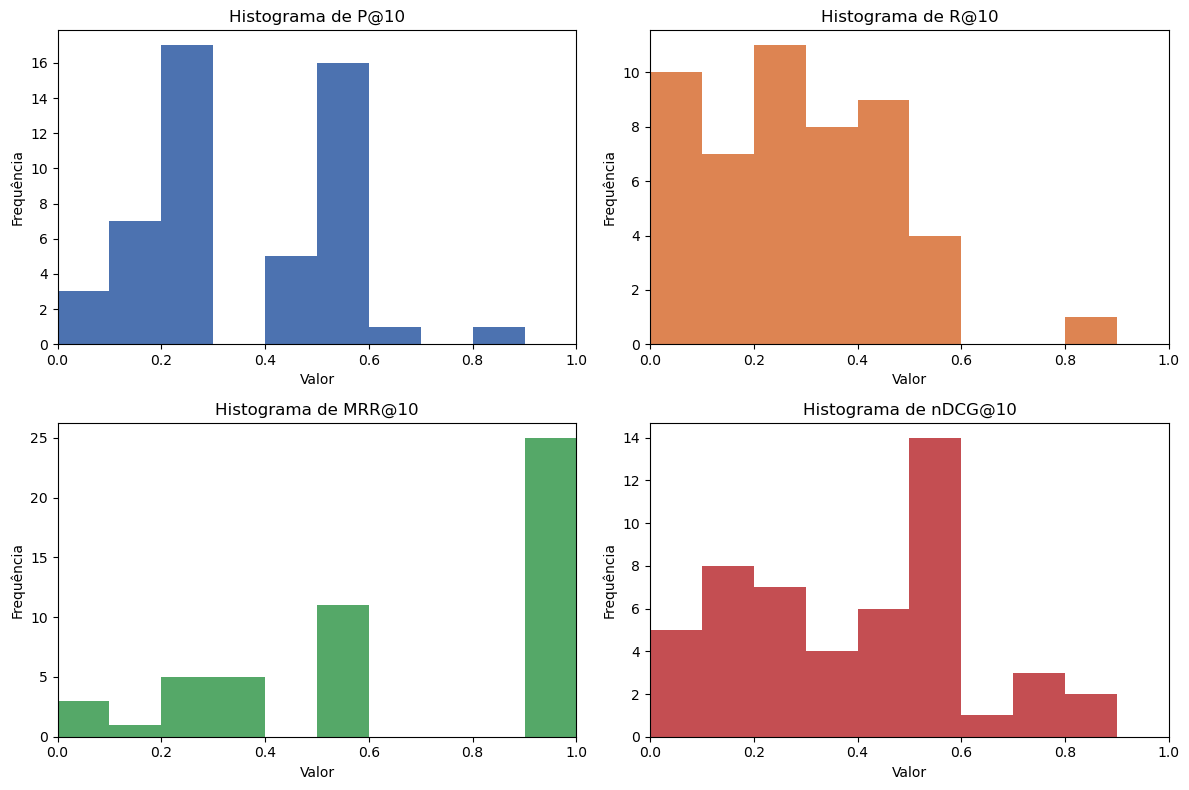

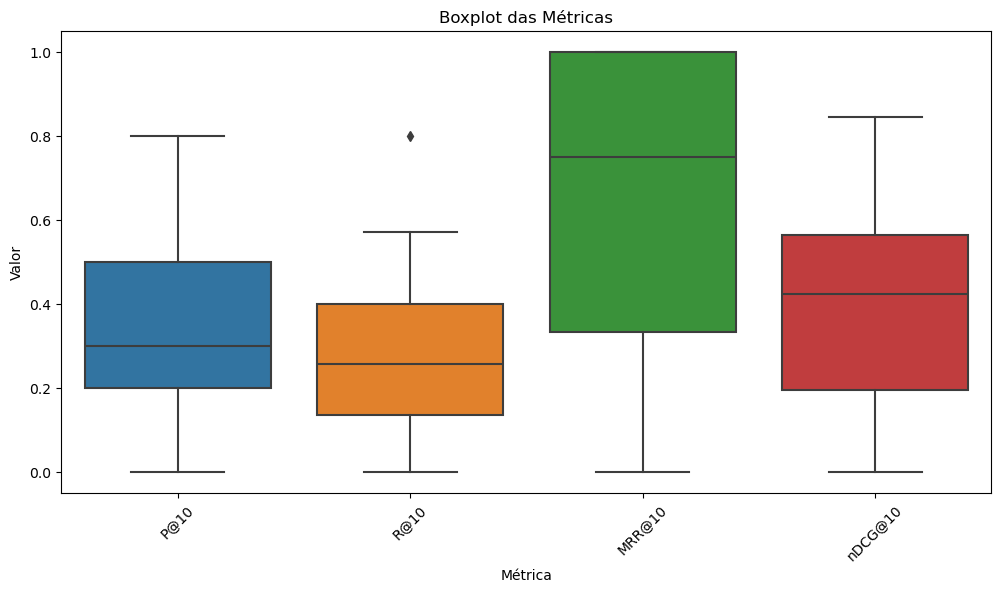

In [12]:
from metricas import histograma_metricas, boxplot_metricas

# Resultados para o primeiro grupo de queries, Llama:
display(df_metricas_llama[0:50].describe())
histograma_metricas(df_metricas_llama[0:50])
boxplot_metricas(df_metricas_llama[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.548000,0.412000,0.278000,0.145600,0.229654,0.346687,0.464850,0.604973,0.920000,0.928413,0.928413,0.928413,0.631049,0.561917,0.601220,0.661293
std,14.57738,0.288019,0.222821,0.132926,0.050312,0.124469,0.202673,0.240127,0.222478,0.254751,0.224200,0.224200,0.224200,0.240817,0.201164,0.196740,0.174859
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.076923,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.083803,0.140989,0.140989
25%,63.25000,0.400000,0.200000,0.150000,0.120000,0.145604,0.180556,0.275974,0.461538,1.000000,1.000000,1.000000,1.000000,0.487289,0.452204,0.469801,0.569494
50%,75.50000,0.600000,0.400000,0.300000,0.160000,0.230769,0.333333,0.441558,0.615385,1.000000,1.000000,1.000000,1.000000,0.658462,0.606741,0.609256,0.684128
75%,87.75000,0.800000,0.600000,0.400000,0.180000,0.326923,0.454545,0.615385,0.764423,1.000000,1.000000,1.000000,1.000000,0.786489,0.693339,0.741257,0.786177
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.500000,0.800000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.909499,0.987818,0.987818


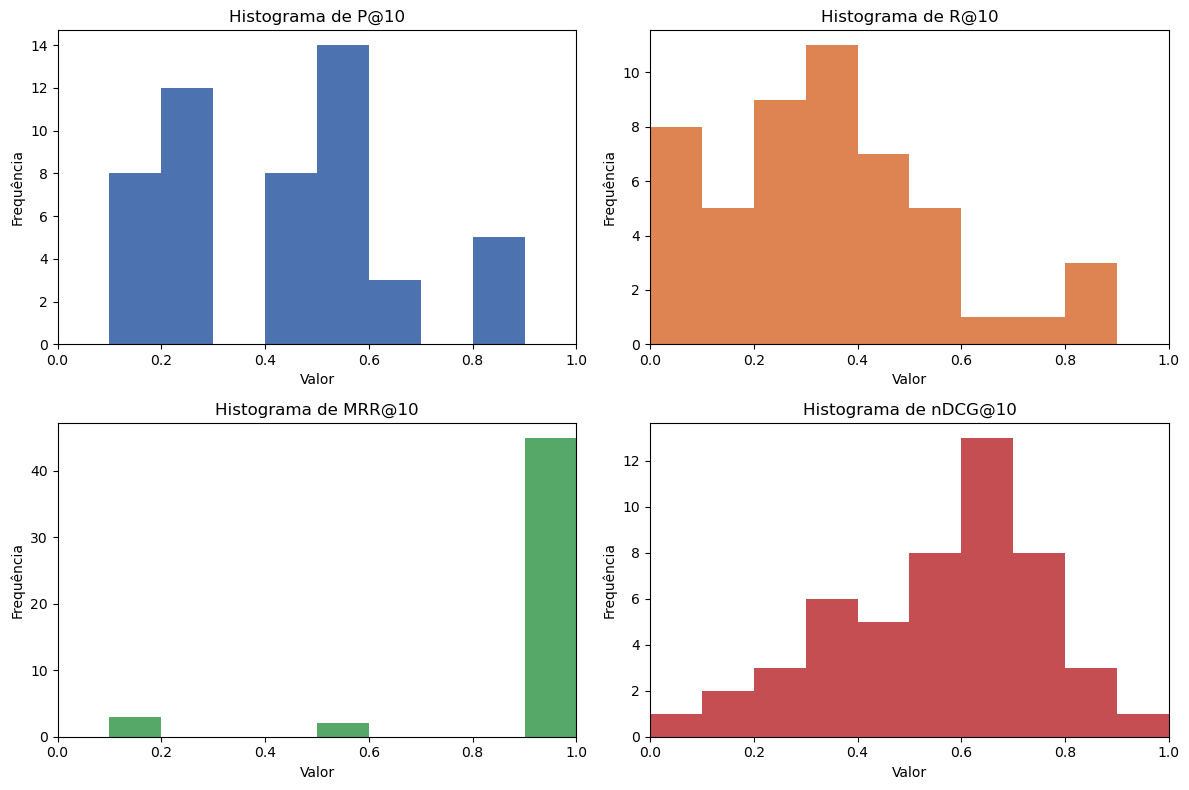

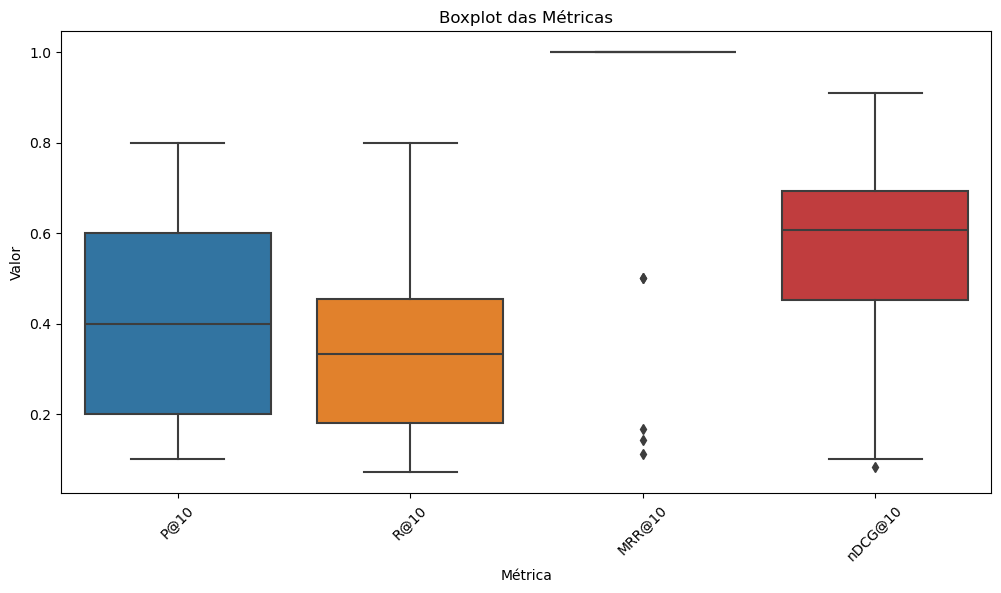

In [13]:
# Resultados para o segundo grupo de queries, Llama:
display(df_metricas_llama[50:100].describe())
histograma_metricas(df_metricas_llama[50:100])
boxplot_metricas(df_metricas_llama[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.556000,0.400000,0.273000,0.141200,0.249696,0.355171,0.481674,0.622287,0.95400,0.956222,0.956222,0.956222,0.641191,0.553901,0.607245,0.663038
std,14.57738,0.259639,0.204041,0.127859,0.049555,0.124706,0.177990,0.223146,0.217464,0.19082,0.179813,0.179813,0.179813,0.212083,0.189092,0.183786,0.161427
min,101.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.066667,0.071429,0.100000,0.00000,0.111111,0.111111,0.111111,0.000000,0.095637,0.268134,0.322422
25%,113.25000,0.400000,0.200000,0.200000,0.105000,0.166667,0.207692,0.321678,0.538462,1.00000,1.000000,1.000000,1.000000,0.507751,0.437985,0.491992,0.530763
50%,125.50000,0.600000,0.400000,0.275000,0.140000,0.250000,0.333333,0.500000,0.636364,1.00000,1.000000,1.000000,1.000000,0.635483,0.574662,0.623224,0.667941
75%,137.75000,0.800000,0.500000,0.350000,0.180000,0.333333,0.500000,0.600000,0.750000,1.00000,1.000000,1.000000,1.000000,0.819557,0.700790,0.751715,0.786946
max,150.00000,1.000000,0.800000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.899809,0.964324,0.964324


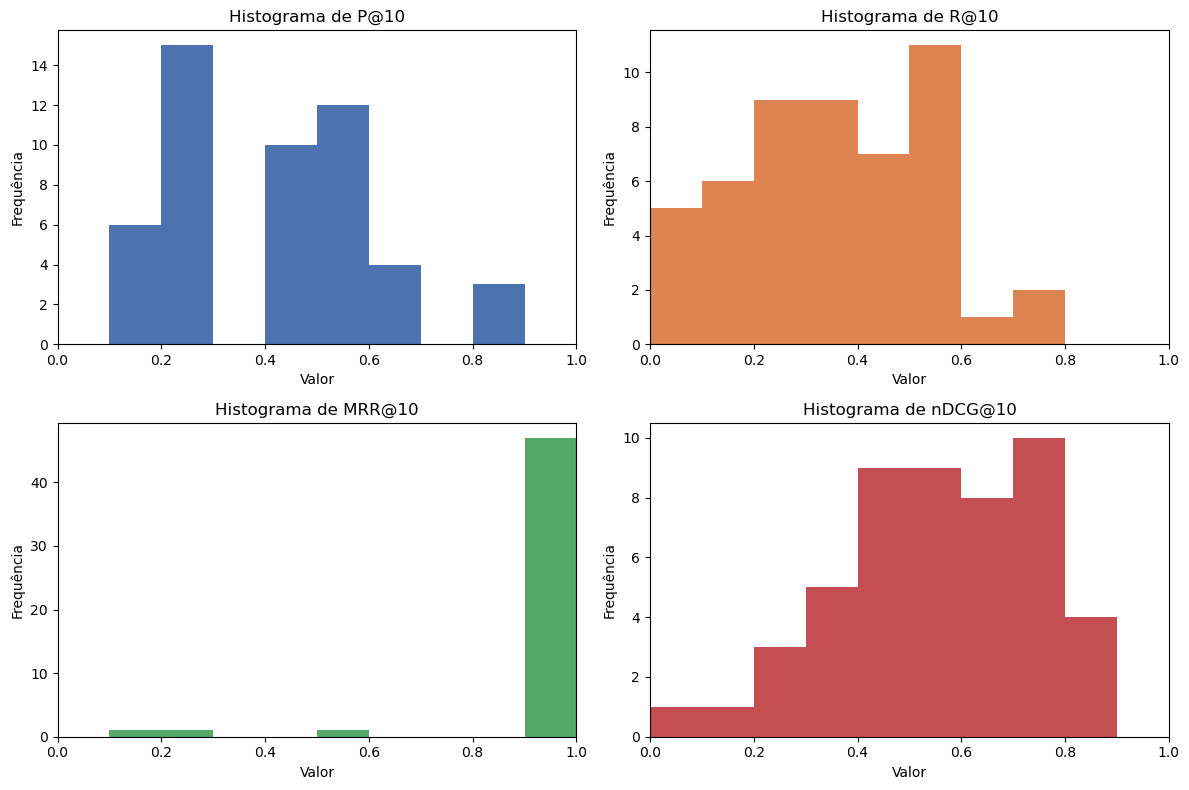

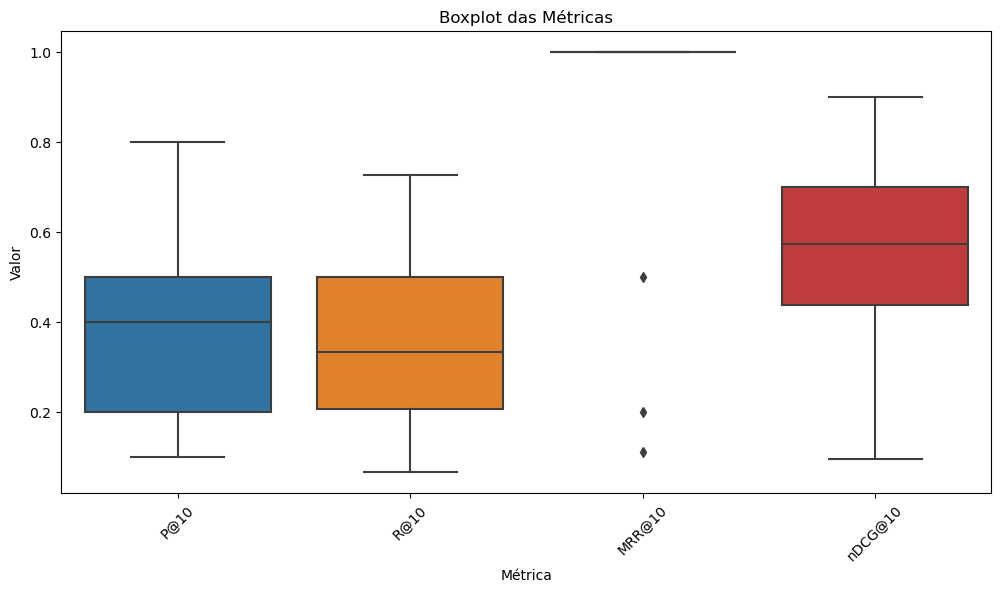

In [14]:
# Resultados para o terceiro grupo de queries, Llama:
display(df_metricas_llama[100:150].describe())
histograma_metricas(df_metricas_llama[100:150])
boxplot_metricas(df_metricas_llama[100:150])

## 3.2 Resultados GPT

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.428000,0.342000,0.261000,0.142800,0.171907,0.279311,0.427691,0.582072,0.648667,0.648667,0.653732,0.653732,0.428713,0.390546,0.458256,0.531578
std,14.57738,0.268054,0.190692,0.115304,0.050469,0.111264,0.168412,0.211774,0.238020,0.360254,0.360254,0.351416,0.351416,0.273935,0.228642,0.225858,0.212469
min,1.00000,0.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.066667,0.133333,0.000000,0.000000,0.071429,0.071429,0.000000,0.000000,0.038953,0.077322
25%,13.25000,0.200000,0.200000,0.162500,0.100000,0.083333,0.142857,0.254167,0.419643,0.333333,0.333333,0.333333,0.333333,0.213986,0.215035,0.239141,0.372515
50%,25.50000,0.400000,0.300000,0.250000,0.150000,0.148352,0.258333,0.416667,0.577381,0.500000,0.500000,0.500000,0.500000,0.372937,0.361942,0.455913,0.579813
75%,37.75000,0.600000,0.500000,0.337500,0.195000,0.257692,0.396154,0.543706,0.792308,1.000000,1.000000,1.000000,1.000000,0.628448,0.578534,0.644290,0.706544
max,50.00000,1.000000,0.700000,0.500000,0.220000,0.500000,0.700000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.846550,0.845184,0.876711


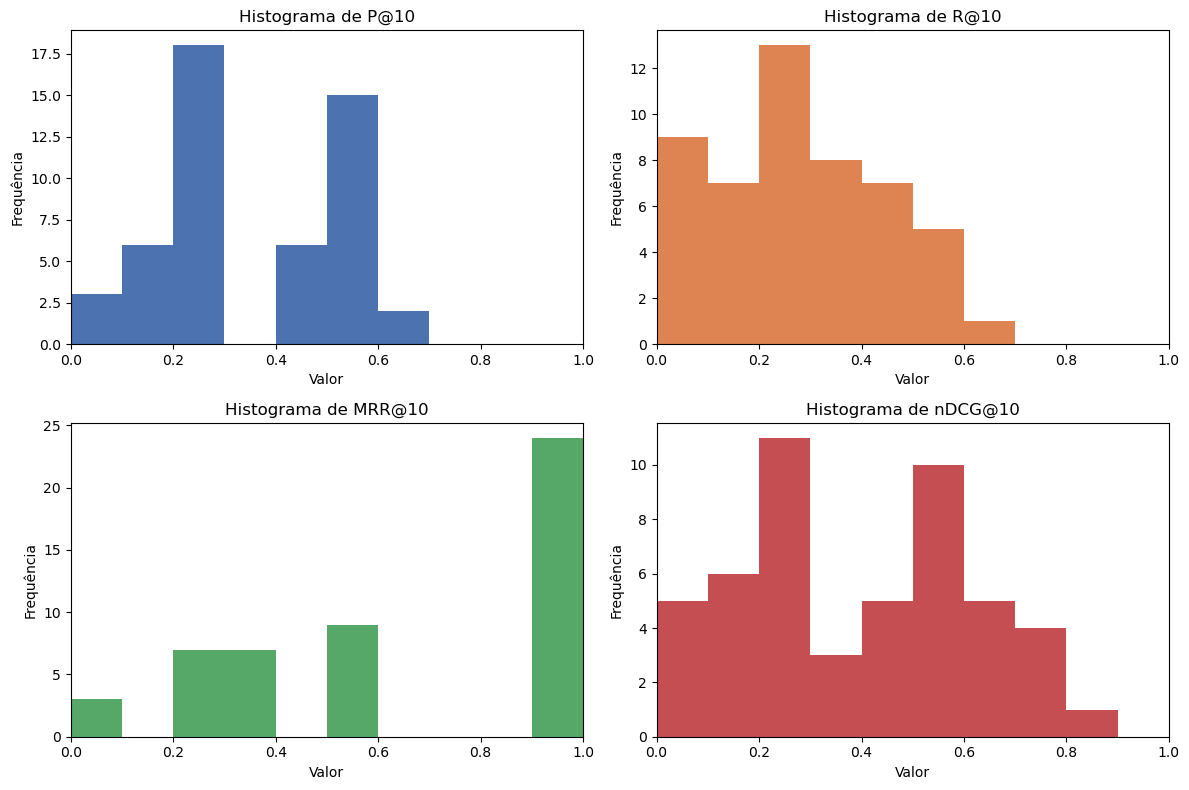

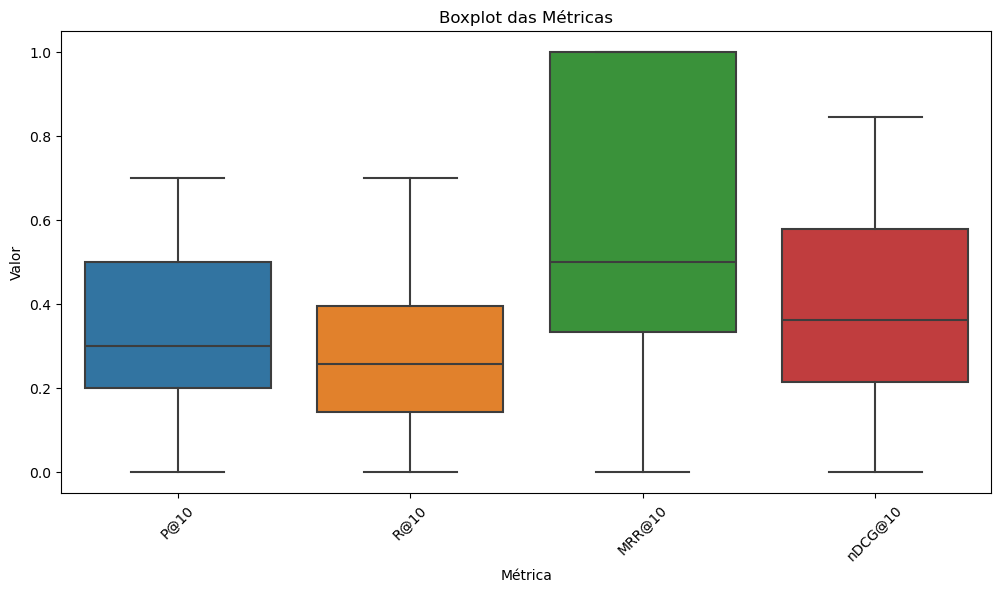

In [15]:
# Resultados para o primeiro grupo de queries, GPT:
display(df_metricas_gpt[0:50].describe())
histograma_metricas(df_metricas_gpt[0:50])
boxplot_metricas(df_metricas_gpt[0:50])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,75.50000,0.576000,0.414000,0.285000,0.148800,0.241330,0.348331,0.476558,0.618349,0.899000,0.904556,0.904556,0.904556,0.646384,0.563438,0.606155,0.667187
std,14.57738,0.272973,0.221323,0.123821,0.047494,0.119912,0.201223,0.223127,0.213288,0.265055,0.246675,0.246675,0.246675,0.232413,0.196861,0.191872,0.176911
min,51.00000,0.000000,0.100000,0.050000,0.020000,0.000000,0.071429,0.083333,0.083333,0.000000,0.111111,0.111111,0.111111,0.000000,0.051685,0.150664,0.150664
25%,63.25000,0.400000,0.200000,0.162500,0.120000,0.157051,0.216270,0.307692,0.461538,1.000000,1.000000,1.000000,1.000000,0.536450,0.452204,0.516529,0.577403
50%,75.50000,0.600000,0.400000,0.300000,0.160000,0.250000,0.333333,0.461538,0.625874,1.000000,1.000000,1.000000,1.000000,0.691820,0.596595,0.640463,0.700763
75%,87.75000,0.800000,0.600000,0.400000,0.180000,0.333333,0.448052,0.615385,0.764423,1.000000,1.000000,1.000000,1.000000,0.800042,0.689708,0.730404,0.799897
max,100.00000,1.000000,0.800000,0.500000,0.200000,0.500000,0.800000,0.900000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.909499,0.924714,0.971476


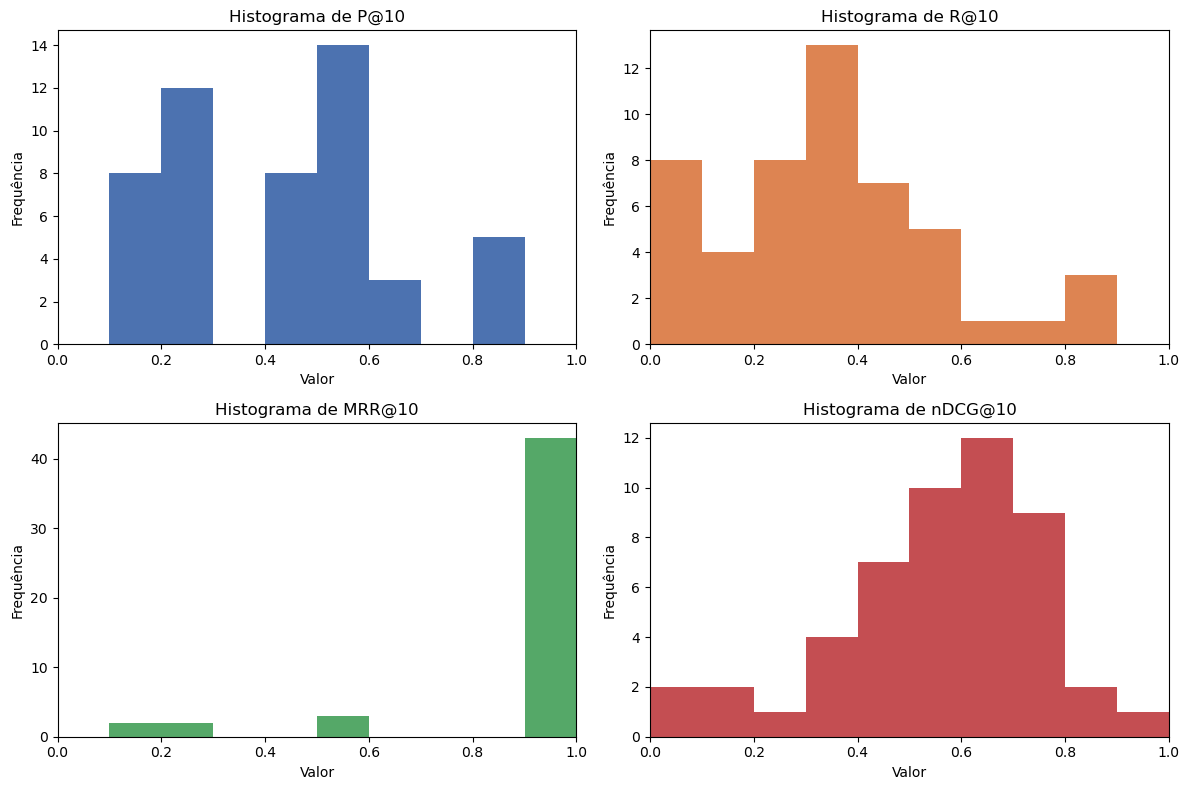

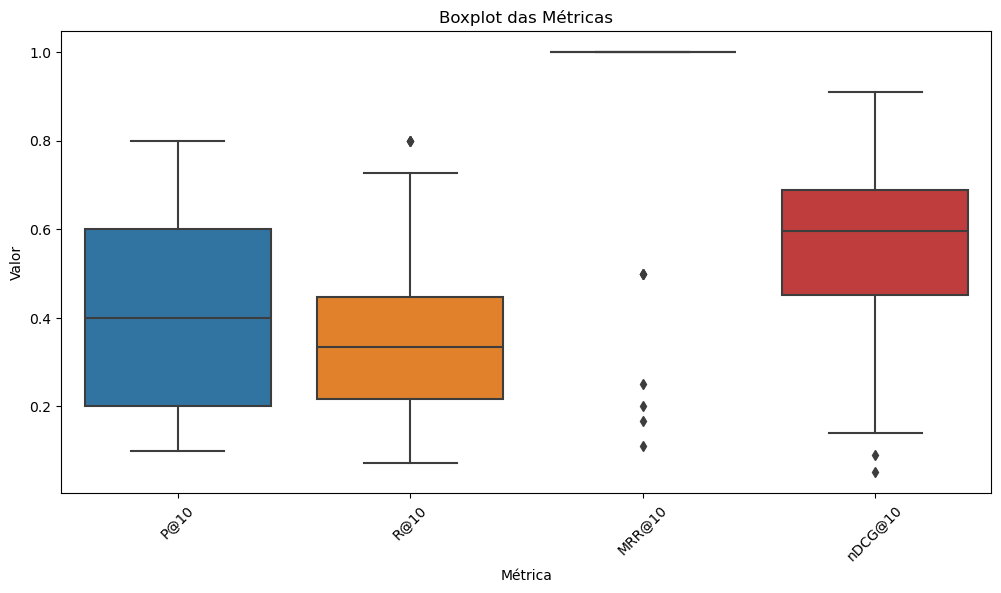

In [16]:
# Resultados para o segundo grupo de queries, GPT:
display(df_metricas_gpt[50:100].describe())
histograma_metricas(df_metricas_gpt[50:100])
boxplot_metricas(df_metricas_gpt[50:100])

,QUERY_KEY,P@5,P@10,P@20,P@50,R@5,R@10,R@20,R@50,MRR@5,MRR@10,MRR@20,MRR@50,nDCG@5,nDCG@10,nDCG@20,nDCG@50
count,50.00000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,125.50000,0.528000,0.40000,0.277000,0.140800,0.237370,0.355061,0.488919,0.620212,0.94400,0.946222,0.946222,0.946222,0.618955,0.548850,0.604367,0.656554
std,14.57738,0.257967,0.20702,0.125848,0.051581,0.122998,0.181654,0.220624,0.224684,0.20118,0.190891,0.190891,0.190891,0.214546,0.187658,0.181888,0.165435
min,101.00000,0.000000,0.10000,0.050000,0.020000,0.000000,0.066667,0.090909,0.100000,0.00000,0.111111,0.111111,0.111111,0.000000,0.070969,0.271356,0.271356
25%,113.25000,0.400000,0.20000,0.200000,0.100000,0.157051,0.207692,0.366477,0.500000,1.00000,1.000000,1.000000,1.000000,0.493011,0.416972,0.462743,0.517801
50%,125.50000,0.400000,0.40000,0.275000,0.140000,0.207143,0.333333,0.500000,0.639610,1.00000,1.000000,1.000000,1.000000,0.607863,0.574662,0.622057,0.678717
75%,137.75000,0.800000,0.57500,0.350000,0.180000,0.333333,0.461538,0.611538,0.764423,1.00000,1.000000,1.000000,1.000000,0.780605,0.696787,0.750557,0.772281
max,150.00000,1.000000,0.80000,0.500000,0.220000,0.500000,0.727273,0.909091,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.899809,0.964670,0.964670


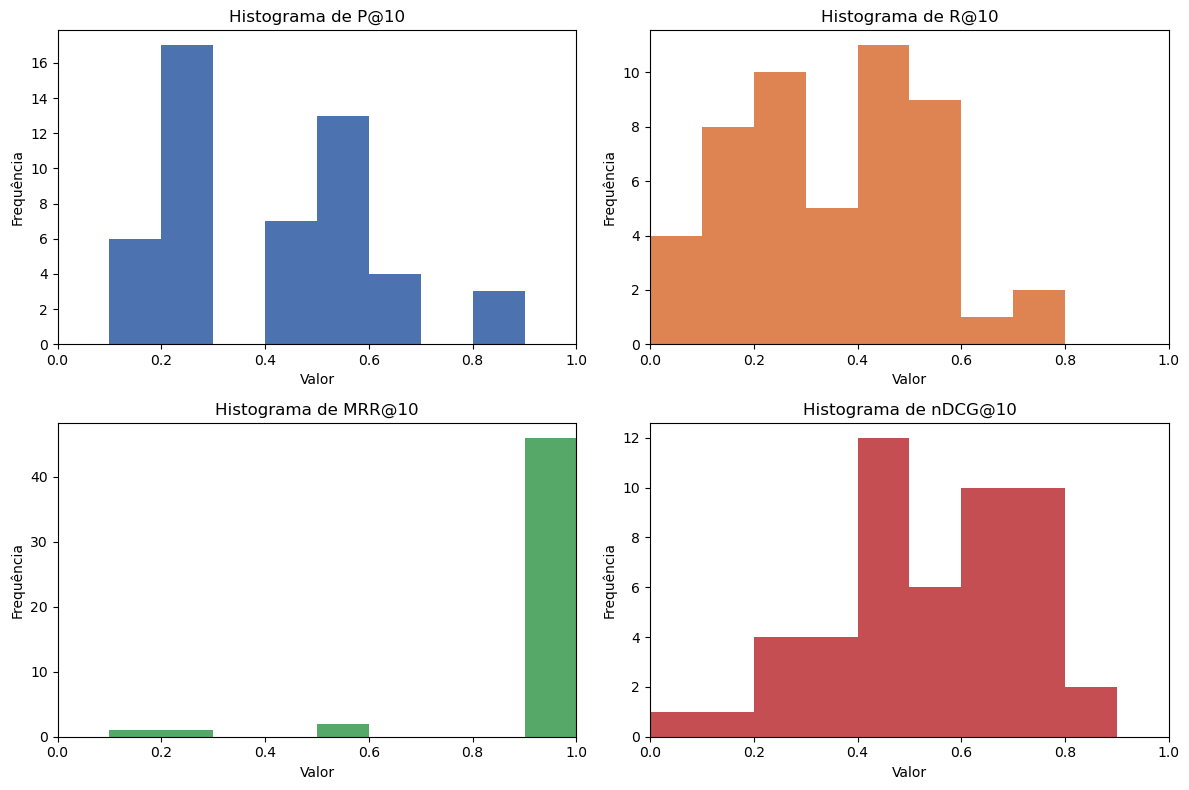

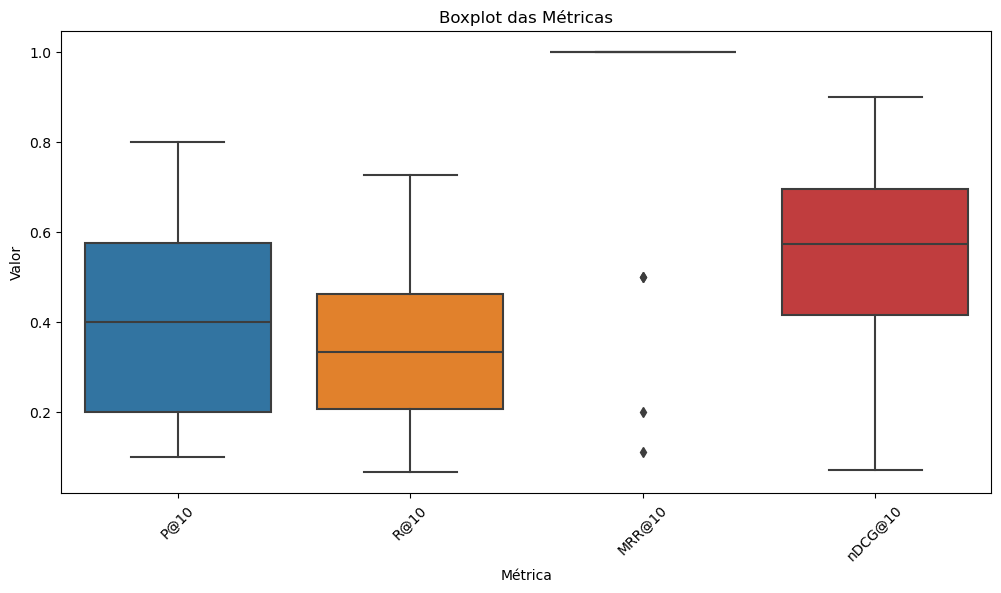

In [17]:
# Resultados para o terceiro grupo de queries, GPT:
display(df_metricas_gpt[100:150].describe())
histograma_metricas(df_metricas_gpt[100:150])
boxplot_metricas(df_metricas_gpt[100:150])